# 1. Setup and Installations

In [1]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.8/330.8 kB 8.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 94.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 43.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.5 MB/s eta 0:00:00:00:0100:01
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f43f1b90e2e8817511dfd68a988e39a6797cec6d83799b952adcbb1b7ca4cb5c
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.1
    

# 2. Imports and Logging Setup

In [ ]:
import os
import json
import logging
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from datetime import datetime
from simpletransformers.question_answering import QuestionAnsweringModel

In [32]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [4]:
print("PyTorch version:", torch.__version__)
print("Using CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

PyTorch version: 2.6.0+cu124
Using CUDA: True
CUDA device: Tesla T4


# 3. Download SQuAD 1.1 Dataset

In [5]:
os.makedirs("data", exist_ok=True)

# Download files
print("Downloading SQuAD v1.1 dataset...")
!wget -q -O data/train-v1.1.json https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
!wget -q -O data/dev-v1.1.json https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json

print("Files downloaded:", os.listdir("data"))


Files downloaded: ['dev-v1.1.json', 'train-v1.1.json']


In [6]:
# Inspect dataset structure
with open("data/train-v1.1.json", "r", encoding="utf-8") as f:
    squad_train_raw = json.load(f)

print("\nDataset keys:", squad_train_raw.keys())
print("Number of articles:", len(squad_train_raw["data"]))
print("Version:", squad_train_raw["version"])



Dataset keys: dict_keys(['data', 'version'])
Number of articles: 442
Version: 1.1


# 4. Data Exploration and Statistics

In [7]:
def explore_squad_data(file_path):
  #Analyze SQuAD dataset statistics

  with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

  stats = {
  'total_articles': 0,
  'total_paragraphs': 0,
  'total_questions': 0,
  'context_lengths': [],
  'question_lengths': [],
  'answer_lengths': [],
  'answer_positions': []
  }

  for article in data["data"]:
    stats['total_articles'] += 1
    for para in article["paragraphs"]:
      stats['total_paragraphs'] += 1
      context_len = len(para["context"].split())
      stats['context_lengths'].append(context_len)

      for qa in para["qas"]:
          stats['total_questions'] += 1
          stats['question_lengths'].append(len(qa["question"].split()))

          if qa.get("answers"):
              answer = qa["answers"][0]
              stats['answer_lengths'].append(len(answer["text"].split()))
              stats['answer_positions'].append(answer["answer_start"])

  return stats

In [8]:
print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)

train_stats = explore_squad_data("data/train-v1.1.json")
dev_stats = explore_squad_data("data/dev-v1.1.json")

print("\nTraining Set:")
print(f"  Articles: {train_stats['total_articles']}")
print(f"  Paragraphs: {train_stats['total_paragraphs']}")
print(f"  Questions: {train_stats['total_questions']}")
print(f"  Avg context length: {np.mean(train_stats['context_lengths']):.1f} words")
print(f"  Avg question length: {np.mean(train_stats['question_lengths']):.1f} words")
print(f"  Avg answer length: {np.mean(train_stats['answer_lengths']):.1f} words")

print("\nDevelopment Set:")
print(f"  Articles: {dev_stats['total_articles']}")
print(f"  Paragraphs: {dev_stats['total_paragraphs']}")
print(f"  Questions: {dev_stats['total_questions']}")
print(f"  Avg context length: {np.mean(dev_stats['context_lengths']):.1f} words")
print(f"  Avg question length: {np.mean(dev_stats['question_lengths']):.1f} words")
print(f"  Avg answer length: {np.mean(dev_stats['answer_lengths']):.1f} words")


DATASET STATISTICS

Training Set:
  Articles: 442
  Paragraphs: 18896
  Questions: 87599
  Avg context length: 116.6 words
  Avg question length: 10.1 words
  Avg answer length: 3.2 words

Development Set:
  Articles: 48
  Paragraphs: 2067
  Questions: 10570
  Avg context length: 122.8 words
  Avg question length: 10.2 words
  Avg answer length: 3.0 words


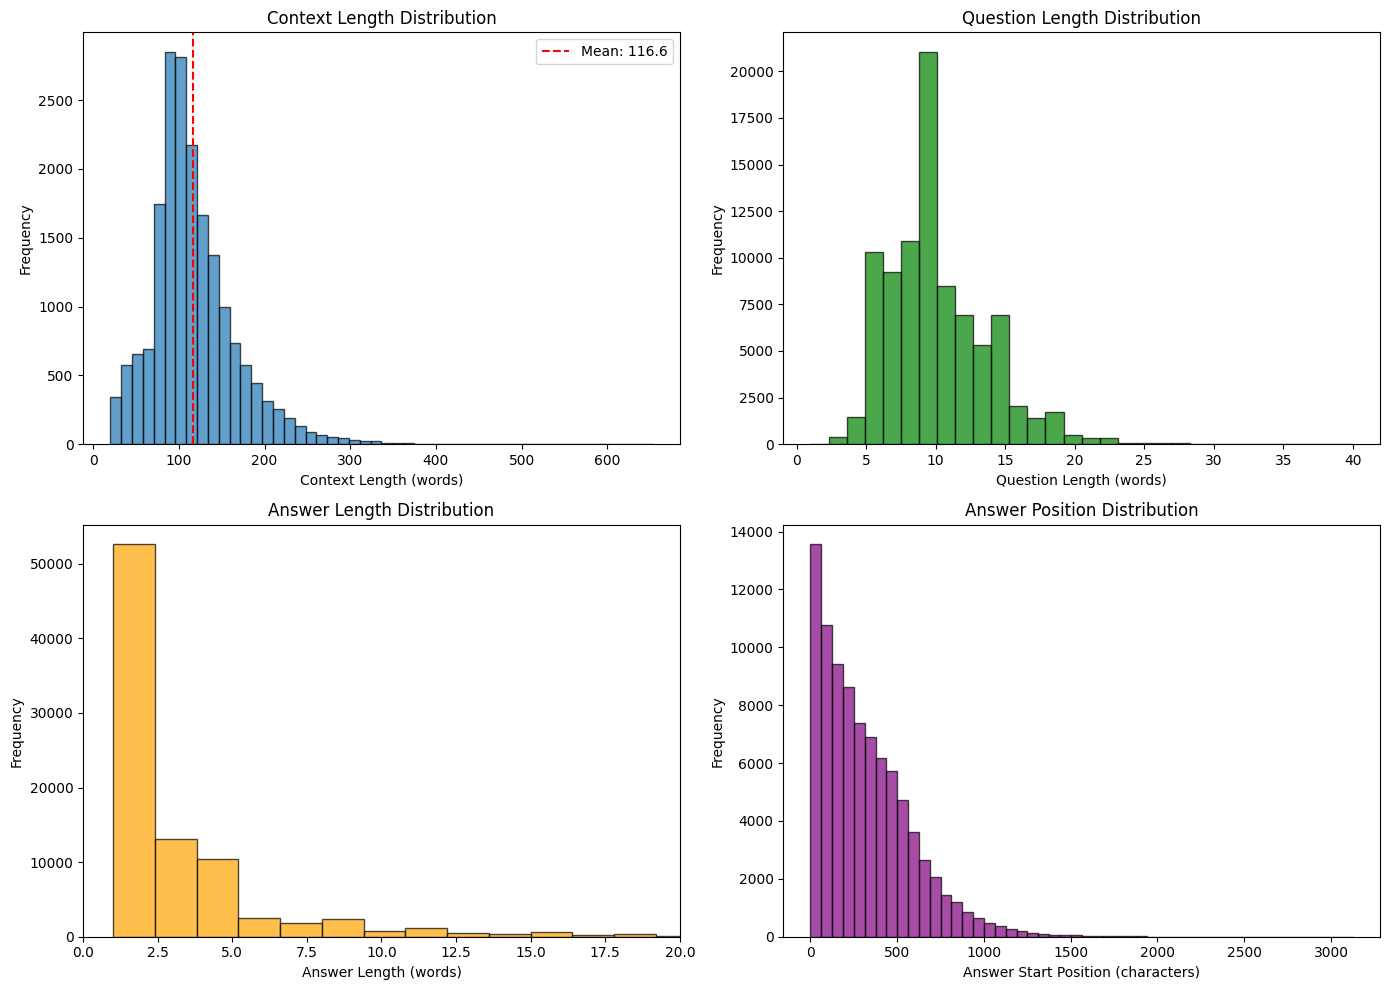

In [9]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(train_stats['context_lengths'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Context Length (words)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Context Length Distribution')
axes[0, 0].axvline(np.mean(train_stats['context_lengths']), color='red',
                    linestyle='--', label=f'Mean: {np.mean(train_stats["context_lengths"]):.1f}')
axes[0, 0].legend()

axes[0, 1].hist(train_stats['question_lengths'], bins=30, alpha=0.7,
                color='green', edgecolor='black')
axes[0, 1].set_xlabel('Question Length (words)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Question Length Distribution')

axes[1, 0].hist(train_stats['answer_lengths'], bins=30, alpha=0.7,
                color='orange', edgecolor='black')
axes[1, 0].set_xlabel('Answer Length (words)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Answer Length Distribution')
axes[1, 0].set_xlim(0, 20)

axes[1, 1].hist(train_stats['answer_positions'], bins=50, alpha=0.7,
                color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Answer Start Position (characters)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Answer Position Distribution')

plt.tight_layout()
plt.savefig('dataset_statistics.png', dpi=300, bbox_inches='tight')
plt.show()


# 5. Convert SQuAD to SimpleTransformers Format

In [10]:
def squad_to_simpletransformers(input_path):
    """Convert SQuAD v1.1 to SimpleTransformers format"""

    with open(input_path, "r", encoding="utf-8") as f:
        squad = json.load(f)

    converted = []
    skipped_count = 0

    for article in squad["data"]:
        for para in article["paragraphs"]:
            context = para["context"]
            qas_list = []

            for qa in para["qas"]:
                answers = qa.get("answers", [])

                if not answers:
                    skipped_count += 1
                    continue

                qas_entry = {
                    "id": qa["id"],
                    "is_impossible": False,
                    "question": qa["question"],
                    "answers": answers,
                }
                qas_list.append(qas_entry)

            if qas_list:
                converted.append({"context": context, "qas": qas_list})

    if skipped_count > 0:
        print(f"Skipped {skipped_count} questions without answers")

    return converted

print("\nConverting datasets...")
train_data = squad_to_simpletransformers("data/train-v1.1.json")
dev_data = squad_to_simpletransformers("data/dev-v1.1.json")

print(f"Training contexts: {len(train_data)}")
print(f"Development contexts: {len(dev_data)}")



Converting datasets...
Training contexts: 18896
Development contexts: 2067


In [11]:
# Save converted data
with open("data/train_simple.json", "w", encoding="utf-8") as f:
    json.dump(train_data, f)

with open("data/dev_simple.json", "w", encoding="utf-8") as f:
    json.dump(dev_data, f)

print("\nSample converted entry:")
print(json.dumps(train_data[0], indent=2)[:500] + "...")



Sample converted entry:
{
  "context": "Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend \"Venite Ad Me Omnes\". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the V...


In [ ]:
import random

half = len(train_data) // 2
small_train = random.sample(train_data, half)

with open("data/train_simple.json", "w", encoding="utf-8") as f:
    json.dump(small_train, f, ensure_ascii=False, indent=2)


# 6. Evaluation Metrics Implementation

In [ ]:
def normalize_answer(s):
    #Lower text and remove punctuation, articles and extra whitespace
    import re
    import string
    
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    
    def white_space_fix(text):
        return ' '.join(text.split())
    
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    
    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [ ]:

def exact_match_score(prediction, ground_truth):
    #Compute exact match score
    return int(normalize_answer(prediction) == normalize_answer(ground_truth))

def f1_score(prediction, ground_truth):
    #Compute F1 score.
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    
    common = set(prediction_tokens) & set(ground_truth_tokens)
    num_same = len(common)
    
    if num_same == 0:
        return 0
    
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    
    return f1

In [23]:
def build_question_lookup(eval_data):
    # lookup dictionary mapping question IDs to their context, question, and answers.
    
    q_id_to_qa = {}
    for article in eval_data:
        context = article['context']
        for qa in article['qas']:
            q_id_to_qa[qa['id']] = {
                'context': context,
                'question': qa['question'],
                'true_answers': [ans['text'] for ans in qa['answers']]
            }
    return q_id_to_qa     # dictionary mapping question IDs to question data

In [35]:

def normalize_predictions(model_predictions):
    
    predictions_list = []
    
    # Check if predictions are in the categorized format
    if isinstance(model_predictions, dict):
        # Check for the three category keys
        has_categories = all(k in model_predictions for k in ['correct_text', 'similar_text', 'incorrect_text'])
        
        if has_categories:
            logger.info("Detected categorized prediction format (correct_text, similar_text, incorrect_text)")
            
            # Process correct predictions (simple string format)
            if 'correct_text' in model_predictions:
                correct_dict = model_predictions['correct_text']
                logger.info(f"Processing {len(correct_dict)} correct predictions")
                
                for q_id, answer in correct_dict.items():
                    predictions_list.append({
                        'id': q_id,
                        'answer': answer,
                        'probability': None,  # Not provided for correct answers
                        'category': 'correct'
                    })
            
            # Process similar predictions (dict format with truth/predicted)
            if 'similar_text' in model_predictions:
                similar_dict = model_predictions['similar_text']
                logger.info(f"Processing {len(similar_dict)} similar predictions")
                
                for q_id, pred_data in similar_dict.items():
                    if isinstance(pred_data, dict):
                        predictions_list.append({
                            'id': q_id,
                            'answer': pred_data.get('predicted', ''),
                            'probability': None,
                            'category': 'similar',
                            'truth': pred_data.get('truth', ''),
                            'question': pred_data.get('question', '')
                        })
                    else:
                        # Fallback if format is different
                        predictions_list.append({
                            'id': q_id,
                            'answer': pred_data,
                            'probability': None,
                            'category': 'similar'
                        })
            
            # Process incorrect predictions (dict format with truth/predicted)
            if 'incorrect_text' in model_predictions:
                incorrect_dict = model_predictions['incorrect_text']
                logger.info(f"Processing {len(incorrect_dict)} incorrect predictions")
                
                for q_id, pred_data in incorrect_dict.items():
                    if isinstance(pred_data, dict):
                        predictions_list.append({
                            'id': q_id,
                            'answer': pred_data.get('predicted', ''),
                            'probability': None,
                            'category': 'incorrect',
                            'truth': pred_data.get('truth', ''),
                            'question': pred_data.get('question', '')
                        })
                    else:
                        # Fallback if format is different
                        predictions_list.append({
                            'id': q_id,
                            'answer': pred_data,
                            'probability': None,
                            'category': 'incorrect'
                        })
            
            logger.info(f"Total predictions after normalization: {len(predictions_list)}")
            return predictions_list
        
        else:
            # Old format: flat dictionary with question IDs as keys
            logger.info("Detected flat dictionary format")
            for k, v in model_predictions.items():
                if isinstance(v, dict):
                    pred = {"id": k, **v}
                else:
                    pred = {"id": k, "answer": v}
                predictions_list.append(pred)
            return predictions_list
    
    else:
        # Already a list
        logger.info(f"Predictions already in list format with {len(model_predictions)} items")
        return model_predictions

In [1]:

def analyze_predictions(model_predictions, q_id_to_qa):
    
    # Normalize predictions to list format
    predictions_list = normalize_predictions(model_predictions)
    
    logger.info(f"Processing {len(predictions_list)} predictions after normalization")
    
    misclassified_examples = []
    correct_examples = []
    skipped_count = 0
    
    for qa_pred in predictions_list:
        q_id = qa_pred.get("id")
        
        if q_id is None:
            logger.warning(f"Skipping prediction with missing ID")
            skipped_count += 1
            continue
            
        if q_id not in q_id_to_qa:
            logger.debug(f"Prediction ID not found in original data: {q_id}")
            skipped_count += 1
            continue
        
        # Extract prediction
        pred_answer = qa_pred.get("answer", "")
        if isinstance(pred_answer, list):
            pred_answer = pred_answer[0] if pred_answer else ""
        
        # Get probability if available
        probability = qa_pred.get("probability")
        if probability and isinstance(probability, list):
            probability = probability[0]
        
        # Get category if available
        category = qa_pred.get("category", "unknown")
        
        # Get true data
        qa_true = q_id_to_qa[q_id]
        true_answers = qa_true["true_answers"]
        question = qa_true["question"]
        context = qa_true["context"]
        
        # Compute metrics across all true answers
        em_scores = [exact_match_score(pred_answer, t) for t in true_answers]
        f1_scores = [f1_score(pred_answer, t) for t in true_answers]
        
        em = max(em_scores) if em_scores else 0
        f1 = max(f1_scores) if f1_scores else 0
        
        # Create example record
        example = {
            "question_id": q_id,
            "context": context,
            "question": question,
            "predicted_answer": pred_answer,
            "true_answers": true_answers,
            "probability": probability,
            "exact_match": em,
            "f1_score": f1,
            "category": category
        }
        
        # Add truth if available (for similar/incorrect categories)
        if "truth" in qa_pred:
            example["expected_truth"] = qa_pred["truth"]
        
        # For misclassifications, focus on 'incorrect_text' category
        # This is more efficient and accurate than computing EM for everything
        if category == "incorrect":
            misclassified_examples.append(example)
        elif category == "similar":
            # Similar means partial match (some F1 score but EM=0)
            # Include these as misclassified since EM=0
            misclassified_examples.append(example)
        elif category == "correct":
            correct_examples.append(example)
        else:
            # Fallback: compute EM if category is unknown
            if em == 0:
                misclassified_examples.append(example)
            else:
                correct_examples.append(example)
    
    if skipped_count > 0:
        logger.info(f"Skipped {skipped_count} predictions (not found in eval data)")
    
    logger.info(f"Found {len(misclassified_examples)} misclassified (incorrect + similar)")
    logger.info(f"  - From 'incorrect' category: {sum(1 for e in misclassified_examples if e['category'] == 'incorrect')}")
    logger.info(f"  - From 'similar' category: {sum(1 for e in misclassified_examples if e['category'] == 'similar')}")
    logger.info(f"Found {len(correct_examples)} correct (exact matches)")
    
    return misclassified_examples, correct_examples

In [26]:

def save_misclassified_examples(misclassified_examples, output_file, metadata=None):
    # save misclassified examples to a JSON file.
   
    output_data = {
        "metadata": metadata or {},
        "misclassified_examples": misclassified_examples
    }
    
    # Create output directory if needed
    output_dir = os.path.dirname(output_file)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(output_data, f, indent=2, ensure_ascii=False)
    
    logger.info(f"Saved {len(misclassified_examples)} misclassified examples to {output_file}")

In [27]:

def print_sample_examples(examples, num_samples=5, title="PREDICTIONS"):
    
    print("\n" + "="*70)
    print(title)
    print("="*70)
    
    for i, example in enumerate(examples[:num_samples], 1):
        print(f"\n--- Example {i} ---")
        print(f"Question ID: {example['question_id']}")
        print(f"Question: {example['question']}")
        print(f"Context (first 200 chars): {example['context'][:200]}...")
        print(f"Predicted Answer: {example['predicted_answer']}")
        print(f"True Answers: {example['true_answers']}")
        if example.get('probability'):
            print(f"Probability: {example['probability']:.3f}")
        print(f"Exact Match: {example['exact_match']}")
        print(f"F1 Score: {example['f1_score']:.3f}")

In [ ]:
def compute_em_f1(predictions, references):

    #Compute EM and F1 for a set of predictions

    em_scores = []
    f1_scores = []

    for pred, ref in zip(predictions, references):

        # Handle multiple reference answers (take max score)

        if isinstance(ref, list):
            em = max(exact_match_score(pred, r) for r in ref)
            f1 = max(f1_score(pred, r) for r in ref)
        else:
            em = exact_match_score(pred, ref)
            f1 = f1_score(pred, ref)

        em_scores.append(em)
        f1_scores.append(f1)

    return {
        'exact_match': np.mean(em_scores) * 100,
        'f1': np.mean(f1_scores) * 100,
        'em_scores': em_scores,
        'f1_scores': f1_scores
    }


In [17]:
def perform_error_analysis(model_predictions_flattened, original_eval_data_squad_format, num_examples_to_analyze=None):

    # Build lookup for true data by question ID
    q_id_to_qa_true = {}
    for article in original_eval_data_squad_format:
        context = article['context']
        for qa in article['qas']:
            q_id_to_qa_true[qa['id']] = {
                'context': context,
                'question': qa['question'],
                'true_answers': [ans['text'] for ans in qa['answers']]
            }

    error_cases = []
    correct_cases = []

    # Always treat predictions as a list (same as inference)
    predictions_to_process = model_predictions_flattened

    if num_examples_to_analyze:
        predictions_to_process = predictions_to_process[:num_examples_to_analyze]

    # Iterate through each prediction
    for qa_pred in predictions_to_process:

        q_id = qa_pred.get("id")
        if q_id is None:
            logging.warning(f"Skipping prediction with missing ID: {qa_pred}")
            continue

        if q_id not in q_id_to_qa_true:
            logging.warning(f"Prediction ID not found in original data: {q_id}")
            continue

        # Extract prediction fields
        pred_answer = qa_pred["answer"][0] if isinstance(qa_pred["answer"], list) else qa_pred["answer"]
        probability = qa_pred["probability"][0] if ("probability" in qa_pred and qa_pred["probability"]) else None

        qa_true = q_id_to_qa_true[q_id]
        true_answers = qa_true["true_answers"]
        question = qa_true["question"]
        context = qa_true["context"]

        # Compute EM/F1 across multiple true answers
        em = max(exact_match_score(pred_answer, t) for t in true_answers)
        f1 = max(f1_score(pred_answer, t) for t in true_answers)

        # Build record
        case = {
            "question_id": q_id,
            "context": context,
            "question": question,
            "predicted_answer": pred_answer,
            "true_answers": true_answers,
            "probability": probability,
            "exact_match": em,
            "f1_score": f1,
        }

        if em == 0:
            error_cases.append(case)
        else:
            correct_cases.append(case)

    return error_cases, correct_cases


# 7. Model Training Function

In [ ]:

def train_and_evaluate_model(
    model_type,
    model_name,
    train_file,
    eval_file,
    model_args,
    experiment_name=None
):
    
    if experiment_name is None:
        experiment_name = f"{model_type}_{model_name}"
    
    print("\n" + "="*70)
    print(f"EXPERIMENT: {experiment_name}")
    print(f"Model: {model_type}/{model_name}")
    print("="*70)
    
    # Create model
    logger.info(f"Initializing {model_type}/{model_name}...")
    qa_model = QuestionAnsweringModel(
        model_type,
        model_name,
        args=model_args,
        use_cuda=torch.cuda.is_available(),
    )
    
    # Training
    start_time = datetime.now()
    logger.info(f"Training started at {start_time.strftime('%H:%M:%S')}")
    qa_model.train_model(train_file)
    training_time = (datetime.now() - start_time).total_seconds()
    logger.info(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
    
    # Evaluation
    logger.info("Evaluating on development set...")
    eval_results, predictions = qa_model.eval_model(eval_file)
    
    print("\nEvaluation Metrics:")
    print(json.dumps(eval_results, indent=2))
    
    # Debug: Inspect predictions structure
    logger.info("\n" + "="*70)
    logger.info("PREDICTION STRUCTURE DEBUG")
    logger.info("="*70)
    logger.info(f"Type of predictions: {type(predictions)}")
    
    if isinstance(predictions, dict):
        logger.info(f"Number of keys in predictions dict: {len(predictions)}")
        logger.info(f"Keys in predictions: {list(predictions.keys())[:10]}")
        
        # Sample a non-metadata key if available
        non_metadata_keys = [k for k in predictions.keys() if k not in 
                            {'correct_text', 'similar_text', 'incorrect_text', 'correct', 'similar', 'incorrect'}]
        
        if non_metadata_keys:
            sample_key = non_metadata_keys[0]
            logger.info(f"\nSample prediction (key={sample_key}):")
            logger.info(f"  Value: {predictions[sample_key]}")
            logger.info(f"  Value type: {type(predictions[sample_key])}")
    elif isinstance(predictions, list):
        logger.info(f"Number of predictions in list: {len(predictions)}")
        if predictions:
            logger.info(f"Sample prediction: {predictions[0]}")
    else:
        logger.warning(f"Unexpected predictions type: {type(predictions)}")
    
    logger.info("="*70 + "\n")
    
    # Clean up GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return qa_model, eval_results, predictions, training_time


In [ ]:
def extract_and_save_errors(
    predictions,
    eval_file,
    output_file,
    model_type=None,
    model_name=None,
    experiment_name=None,
    min_examples=5
):

#    Focuses on 'incorrect' category only (true errors where EM=0 and F1≈0)
#    Excludes 'similar' category (partial matches) for cleaner error analysis
 
    # Load original eval data
    logger.info("Loading evaluation data...")
    with open(eval_file, "r", encoding="utf-8") as f:
        eval_data = json.load(f)
    
    # Build question lookup
    logger.info("Building question lookup...")
    q_id_to_qa = build_question_lookup(eval_data)
    
    # Analyze predictions
    logger.info("Analyzing predictions...")
    misclassified, correct = analyze_predictions(predictions, q_id_to_qa)
    
    # Filter to only 'incorrect' category (true errors)
    # Exclude 'similar' category (partial matches) for cleaner error analysis
    original_count = len(misclassified)
    misclassified = [e for e in misclassified if e['category'] == 'incorrect']
    similar_count = original_count - len(misclassified)
    
    logger.info(f"Found {len(misclassified)} true misclassifications (incorrect category)")
    logger.info(f"Excluded {similar_count} partial matches (similar category)")
    logger.info(f"Found {len(correct)} correct predictions (exact matches)")
    
    if len(misclassified) < min_examples:
        logger.warning(
            f"Only found {len(misclassified)} misclassified examples "
            f"(minimum requested: {min_examples})"
        )
    
    # Prepare metadata
    metadata = {
        "timestamp": datetime.now().isoformat(),
        "eval_file": eval_file,
        "total_predictions": len(misclassified) + similar_count + len(correct),
        "misclassified_count": len(misclassified),
        "similar_count": similar_count,
        "correct_count": len(correct),
        "analysis_note": "Only 'incorrect' category included (true errors). 'Similar' category (partial matches) excluded.",
    }
    
    if model_type:
        metadata["model_type"] = model_type
    if model_name:
        metadata["model_name"] = model_name
    if experiment_name:
        metadata["experiment_name"] = experiment_name
    
    # Save misclassified examples
    save_misclassified_examples(misclassified, output_file, metadata)
    
    # Print samples
    if misclassified:
        print_sample_examples(
            misclassified, 
            num_samples=min(5, len(misclassified)),
            title="MISCLASSIFIED EXAMPLES"
        )
    
    return misclassified, correct

In [30]:
def pipeline(
    model_type,
    model_name,
    train_file,
    eval_file,
    model_args,
    output_file=None,
    experiment_name=None,
    min_examples=5
):
    if experiment_name is None:
        experiment_name = f"{model_type}_{model_name.replace('/', '_')}"
    
    if output_file is None:
        output_file = f"outputs/{experiment_name}_misclassified.json"
    
    # Train and evaluate
    model, eval_results, predictions, training_time = train_and_evaluate_model(
        model_type=model_type,
        model_name=model_name,
        train_file=train_file,
        eval_file=eval_file,
        model_args=model_args,
        experiment_name=experiment_name
    )
    
    # Extract errors
    misclassified, correct = extract_and_save_errors(
        predictions=predictions,
        eval_file=eval_file,
        output_file=output_file,
        model_type=model_type,
        model_name=model_name,
        experiment_name=experiment_name,
        min_examples=min_examples
    )
    
    # Return all results
    return {
        "model": model,
        "eval_results": eval_results,
        "predictions": predictions,
        "training_time": training_time,
        "misclassified_examples": misclassified,
        "correct_examples": correct,
        "output_file": output_file
    }

# 8. BERT-base-uncased (Baseline)

In [19]:
bert_args = {
    "learning_rate": 3e-5,
    "num_train_epochs": 1,
    "max_seq_length": 384,
    "doc_stride": 128,
    "train_batch_size": 8,
    "eval_batch_size": 8,
    "n_best_size": 20,
    "max_answer_length": 30,
    "overwrite_output_dir": True,
    "reprocess_input_data": True,
    "do_lower_case": True,
    "output_dir": "outputs/bert-squad",
    "best_model_dir": "outputs/bert-squad/best_model",
    "save_steps": 5000,
    "logging_steps": 500,
    "fp16": False,
}

In [37]:
bert_results = pipeline(
        model_type="bert",
        model_name="bert-base-uncased",
        train_file="data/train_simple.json",
        eval_file="data/dev_simple.json",
        model_args=bert_args,
        experiment_name="BERT_Base_Baseline",
        min_examples=5
    )


EXPERIMENT: BERT_Base_Baseline
Model: bert/bert-base-uncased


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
add example index and unique id: 100%|██████████| 5825/5825 [00:00<00:00, 1182566.35it/s]


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/741 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 10570/10570 [00:00<00:00, 1261059.09it/s]


Running Evaluation:   0%|          | 0/1355 [00:00<?, ?it/s]


Evaluation Metrics:
{
  "correct": 3734,
  "similar": 4198,
  "incorrect": 2638,
  "eval_loss": -5.182714599876826
}


In [ ]:
custom_context = (
    "Natural Language Processing (NLP) is a field of Artificial Intelligence that focuses "
    "on enabling computers to understand and generate human language."
)

to_predict = [
    {
        "context": custom_context,
        "qas": [
            {
                "id": "demo-1",
                "question": "What does NLP focus on?",
            },
            {
                "id": "demo-2",
                "question": "NLP is a subfield of what broader area?",
            },
        ],
    }
]

predictions, raw_outputs = bert_results['model'].predict(to_predict)

# Create mappings for easy lookup
prediction_map = {pred['id']: pred for pred in predictions}
raw_output_map = {output['id']: output for output in raw_outputs}

# Iterate through the original input structure to get the question text
for context_qa_block in to_predict:
    for qa_input in context_qa_block["qas"]:
        qa_id = qa_input["id"]
        question = qa_input["question"]

        # Get the corresponding prediction and raw output
        if qa_id in prediction_map:
            prediction = prediction_map[qa_id]
            # Take the first (most confident) answer from the list
            answer = prediction["answer"][0]

            # Retrieve probability from raw_output_map
            raw_output_entry = raw_output_map.get(qa_id)
            probability = raw_output_entry['probability'][0] if raw_output_entry and 'probability' in raw_output_entry and raw_output_entry['probability'] else None

            print(f"Q ({qa_id}): {question}")
            # Print question, answer and score
            if probability is not None:
                print(f"  -> Answer: {answer!r}, score={probability:.4f}")
            else:
                print(f"  -> Answer: {answer!r}, score=N/A")
        else:
            print(f"Q ({qa_id}): {question}")
            print(f"  -> No prediction found for this question.")



# 9. ALBERT-base-v2

In [ ]:
albert_args = bert_args.copy()
albert_args["output_dir"] = "outputs/albert-squad"
albert_args["best_model_dir"] = "outputs/albert-squad/best_model"

In [ ]:
albert_results = pipeline(
    model_type="albert",
    model_name="albert-base-v2",
    experiment_name="ALBERT-base-v2",
    train_file="data/train_simple.json",
    eval_file="data/dev_simple.json",
    model_args=albert_args,
    min_examples=5
)

In [ ]:
custom_context = (
    "Natural Language Processing (NLP) is a field of Artificial Intelligence that focuses "
    "on enabling computers to understand and generate human language."
)

to_predict = [
    {
        "context": custom_context,
        "qas": [
            {
                "id": "demo-1",
                "question": "What does NLP focus on?",
            },
            {
                "id": "demo-2",
                "question": "NLP is a subfield of what broader area?",
            },
        ],
    }
]

predictions, raw_outputs = albert_results['model'].predict(to_predict)

# Create mappings for easy lookup
prediction_map = {pred['id']: pred for pred in predictions}
raw_output_map = {output['id']: output for output in raw_outputs}

# Iterate through the original input structure to get the question text
for context_qa_block in to_predict:
    for qa_input in context_qa_block["qas"]:
        qa_id = qa_input["id"]
        question = qa_input["question"]

        # Get the corresponding prediction and raw output
        if qa_id in prediction_map:
            prediction = prediction_map[qa_id]
            # Take the first (most confident) answer from the list
            answer = prediction["answer"][0]

            # Retrieve probability from raw_output_map
            raw_output_entry = raw_output_map.get(qa_id)
            probability = raw_output_entry['probability'][0] if raw_output_entry and 'probability' in raw_output_entry and raw_output_entry['probability'] else None

            print(f"Q ({qa_id}): {question}")
            # Print question, answer and score
            if probability is not None:
                print(f"  -> Answer: {answer!r}, score={probability:.4f}")
            else:
                print(f"  -> Answer: {answer!r}, score=N/A")
        else:
            print(f"Q ({qa_id}): {question}")
            print(f"  -> No prediction found for this question.")



# 10. MobileBERT

In [ ]:
mobilebert_args = bert_args.copy()
mobilebert_args["output_dir"] = "outputs/mobilebert-squad"
mobilebert_args["best_model_dir"] = "outputs/mobilebert-squad/best_model"

In [ ]:
mobilebert_results= pipeline(
    model_type="mobilebert",
    model_name="google/mobilebert-uncased",
    train_file="data/train_simple.json",
    eval_file="data/dev_simple.json",
    experiment_name="MobileBERT",
    model_args=mobilebert_args,
    min_examples=5
)

In [ ]:
custom_context = (
    "Natural Language Processing (NLP) is a field of Artificial Intelligence that focuses "
    "on enabling computers to understand and generate human language."
)

to_predict = [
    {
        "context": custom_context,
        "qas": [
            {
                "id": "demo-1",
                "question": "What does NLP focus on?",
            },
            {
                "id": "demo-2",
                "question": "NLP is a subfield of what broader area?",
            },
        ],
    }
]

predictions, raw_outputs = mobilebert_results['model'].predict(to_predict)

# Create mappings for easy lookup
prediction_map = {pred['id']: pred for pred in predictions}
raw_output_map = {output['id']: output for output in raw_outputs}

# Iterate through the original input structure to get the question text
for context_qa_block in to_predict:
    for qa_input in context_qa_block["qas"]:
        qa_id = qa_input["id"]
        question = qa_input["question"]

        # Get the corresponding prediction and raw output
        if qa_id in prediction_map:
            prediction = prediction_map[qa_id]
            # Take the first (most confident) answer from the list
            answer = prediction["answer"][0]

            # Retrieve probability from raw_output_map
            raw_output_entry = raw_output_map.get(qa_id)
            probability = raw_output_entry['probability'][0] if raw_output_entry and 'probability' in raw_output_entry and raw_output_entry['probability'] else None

            print(f"Q ({qa_id}): {question}")
            # Print question, answer and score
            if probability is not None:
                print(f"  -> Answer: {answer!r}, score={probability:.4f}")
            else:
                print(f"  -> Answer: {answer!r}, score=N/A")
        else:
            print(f"Q ({qa_id}): {question}")
            print(f"  -> No prediction found for this question.")



# 11. Hyperparameter Tuning
## No. of Epochs & Learning Rate

In [ ]:
mobilebert_tuned_args = bert_args.copy()
mobilebert_tuned_args["num_train_epochs"] = 5 # initially trained for 1 epoch
mobilebert_tuned_args["learning_rate"] = 5e-5 # initially 3e-5
mobilebert_tuned_args["output_dir"] = "outputs/mobilebert-squad-tuned"
mobilebert_tuned_args["best_model_dir"] = "outputs/mobilebert-squad-tuned/best_model"


In [ ]:
mobilebert_tuned_results= pipeline(
    model_type="mobilebert",
    model_name="google/mobilebert-uncased",
    train_file="data/train_simple.json",
    eval_file="data/dev_simple.json",
    experiment_name="MobileBERT",
    model_args=mobilebert_tuned_args,
    min_examples=5
)

In [ ]:
custom_context = (
    "Natural Language Processing (NLP) is a field of Artificial Intelligence that focuses "
    "on enabling computers to understand and generate human language."
)

to_predict = [
    {
        "context": custom_context,
        "qas": [
            {
                "id": "demo-1",
                "question": "What does NLP focus on?",
            },
            {
                "id": "demo-2",
                "question": "NLP is a subfield of what broader area?",
            },
        ],
    }
]

predictions, raw_outputs = mobilebert_tuned_results['model'].predict(to_predict)

# Create mappings for easy lookup
prediction_map = {pred['id']: pred for pred in predictions}
raw_output_map = {output['id']: output for output in raw_outputs}

# Iterate through the original input structure to get the question text
for context_qa_block in to_predict:
    for qa_input in context_qa_block["qas"]:
        qa_id = qa_input["id"]
        question = qa_input["question"]

        # Get the corresponding prediction and raw output
        if qa_id in prediction_map:
            prediction = prediction_map[qa_id]
            # Take the first (most confident) answer from the list
            answer = prediction["answer"][0]

            # Retrieve probability from raw_output_map
            raw_output_entry = raw_output_map.get(qa_id)
            probability = raw_output_entry['probability'][0] if raw_output_entry and 'probability' in raw_output_entry and raw_output_entry['probability'] else None

            print(f"Q ({qa_id}): {question}")
            # Print question, answer and score
            if probability is not None:
                print(f"  -> Answer: {answer!r}, score={probability:.4f}")
            else:
                print(f"  -> Answer: {answer!r}, score=N/A")
        else:
            print(f"Q ({qa_id}): {question}")
            print(f"  -> No prediction found for this question.")



## Hyperparameter  Tuning - Doc Stride & Max Sequence Length

In [ ]:
albert_tuned_args = bert_args.copy()
albert_tuned_args["output_dir"] = "outputs/albert_tuned-squad"
albert_tuned_args["best_model_dir"] = "outputs/albert_tuned-squad/best_model"
albert_tuned_args["num_train_epochs"] = 3 # initially trained for 1 epoch
albert_tuned_args["doc_stride"] = 256 # initially 128
albert_tuned_args["learning_rate"] = 5e-5 # initially 3e-5
albert_tuned_args["max_seq_length"] = 500 # initially 384

In [ ]:
albert_tuned_results = pipeline(
    model_type="albert",
    model_name="albert-base-v2",
    experiment_name="ALBERT-base-v2",
    train_file="data/train_simple.json",
    eval_file="data/dev_simple.json",
    model_args=albert_tuned_args,
    min_examples=5
)

In [ ]:
custom_context = (
    "Natural Language Processing (NLP) is a field of Artificial Intelligence that focuses "
    "on enabling computers to understand and generate human language."
)

to_predict = [
    {
        "context": custom_context,
        "qas": [
            {
                "id": "demo-1",
                "question": "What does NLP focus on?",
            },
            {
                "id": "demo-2",
                "question": "NLP is a subfield of what broader area?",
            },
        ],
    }
]

predictions, raw_outputs = albert_tuned_results['model'].predict(to_predict)

# Create mappings for easy lookup
prediction_map = {pred['id']: pred for pred in predictions}
raw_output_map = {output['id']: output for output in raw_outputs}

# Iterate through the original input structure to get the question text
for context_qa_block in to_predict:
    for qa_input in context_qa_block["qas"]:
        qa_id = qa_input["id"]
        question = qa_input["question"]

        # Get the corresponding prediction and raw output
        if qa_id in prediction_map:
            prediction = prediction_map[qa_id]
            # Take the first (most confident) answer from the list
            answer = prediction["answer"][0]

            # Retrieve probability from raw_output_map
            raw_output_entry = raw_output_map.get(qa_id)
            probability = raw_output_entry['probability'][0] if raw_output_entry and 'probability' in raw_output_entry and raw_output_entry['probability'] else None

            print(f"Q ({qa_id}): {question}")
            # Print question, answer and score
            if probability is not None:
                print(f"  -> Answer: {answer!r}, score={probability:.4f}")
            else:
                print(f"  -> Answer: {answer!r}, score=N/A")
        else:
            print(f"Q ({qa_id}): {question}")
            print(f"  -> No prediction found for this question.")



# 12. Results Comparison Table

In [ ]:

results_df = pd.DataFrame({
    'Model': ['BERT-base', 'ALBERT-base-v2', 'MobileBERT', 'MobileBERT Tuned', 'ALBERT Tuned'],
    'Exact Match (%)': [
        bert_results['eval_results'].get('exact', 0), 
        albert_results['eval_results'].get('exact', 0),
        mobilebert_results['eval_results'].get('exact', 0),
        mobilebert_tuned_results['eval_results'].get('exact', 0),
        albert_tuned_results['eval_results'].get('exact', 0)
    ],
    'F1 Score (%)': [
        bert_results['eval_results'].get('f1', 0),
        albert_results['eval_results'].get('f1', 0),
        mobilebert_results['eval_results'].get('f1', 0),
        mobilebert_tuned_results['eval_results'].get('f1', 0),
        albert_tuned_results['eval_results'].get('f1', 0)
    ],
    'Training Time (min)': [
        bert_results['training_time']/60,
        albert_results['training_time']/60,
        mobilebert_results['training_time']/60,
        mobilebert_tuned_results['training_time']/60,
        albert_tuned_results['training_time']/60
    ],
    'Parameters': ['110M', '12M', '25M', '25M', '12M']
})

In [ ]:
results_df.sort_values(by='Exact Match (%)', ascending=False, inplace=True)

In [ ]:
results_df

In [ ]:
# Save results
results_df.to_csv('experiment_results.csv', index=False)

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# EM comparison
axes[0].bar(results_df['Model'], results_df['Exact Match (%)'], color='steelblue')
axes[0].set_ylabel('Exact Match (%)')
axes[0].set_title('Exact Match Comparison')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# F1 comparison
axes[1].bar(results_df['Model'], results_df['F1 Score (%)'], color='coral')
axes[1].set_ylabel('F1 Score (%)')
axes[1].set_title('F1 Score Comparison')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Training time comparison
axes[2].bar(results_df['Model'], results_df['Training Time (min)'], color='lightgreen')
axes[2].set_ylabel('Training Time (minutes)')
axes[2].set_title('Training Time Comparison')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
